In [1]:
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
n_cores = multiprocessing.cpu_count()

import sys
import os
import copy 

sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")


import pandas as pd
import numpy as np

In [2]:
## experiment info 

# tissue = 'BRCA'
# target = 'nVSluma'
# network_inf_method = 'WGCNA'
# sex_and_gender = False
# gsea_parent_folder_name = 'WGCNA_PIPE_BRCA_LUMA_NT_e2e_8121620242832_newplots'
# save_gsea_results_notes = ''

tissue = 'LUAD'
target = 'mVSf'
network_inf_method = 'WGCNA'
sex_and_gender = True
gsea_parent_folder_name = 'WGCNA_PIPE_LUAD_mf_e2e_48121620_upd_data_2'
save_gsea_results_notes = ''

# tissue = 'KIRC'
# target = 'mVSf'
# network_inf_method = 'WGCNA'
# sex_and_gender = True
# gsea_parent_folder_name = 'WGCNA_PIPE_KIRC_mf_e2e_48121620_newplots'
# save_gsea_results_notes = ''

# tissue = 'BRCA'
# target = 'nVSt'
# network_inf_method = 'WGCNA'
# sex_and_gender = False
# gsea_parent_folder_name = 'WGCNA_PIPE_BRCA_NT_e2e_48121620_newplots'
# save_gsea_results_notes = ''

In [3]:
from node2vec2rank.dataloader import DataLoader

import json

#read the config file
config = json.load(open('../configs/config_wgcna_LUAD_mf.json', 'r'))
# config = json.load(open('../configs/config_wgcna_BRCA_nt.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

dataloader = DataLoader(config)

There are 26000 row nodes and 26000 column nodes in graph 1
There are 26000 row nodes and 26000 column nodes in graph 2


In [7]:
from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, node_names=dataloader.interest_nodes)
rankings = model.fit_transform_rank()

DeDi_ranking = model.degree_difference_ranking()
borda_rankings = model.aggregate_transform()

signed_rankings = model.signed_ranks_transform()

../output/10_25_2023_02_28_59

Running n2v2r with dimensions [4, 8, 12, 16, 20] and distance metrics ['euclidean', 'cosine'] ...
	UASE embedding in 11.37 seconds for bin=False and keep_top=100%
		Ranking in 4.19 seconds
n2v2r computed 10 rankings for 1 comparison(s) in 61.23 seconds

Rank aggregation with Borda ...
	Finished aggregation in 9.21 seconds

Signed ranks transformation ...
	Finished signed transformation in 2.65 seconds


In [9]:
##get the rankings of the comparison and map the ens to symbols

comparison = '1'
n2v2r_ranking_pd = rankings[comparison].copy()
n2v2r_borda_ranking_pd = borda_rankings[comparison].copy()
n2v2r_DeDi_ranking_pd = signed_rankings[comparison].copy()
n2v2r_borda_DeDi_ranking_pd = model.pairwise_signed_aggregate_ranks[comparison].copy()
DeDi_ranking_pd = DeDi_ranking[comparison].copy()

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

n2v2r_ranking_pd.index = genes_mapped
n2v2r_borda_ranking_pd.index = genes_mapped
n2v2r_DeDi_ranking_pd.index = genes_mapped
n2v2r_borda_DeDi_ranking_pd.index = genes_mapped
DeDi_ranking_pd.index = genes_mapped


In [10]:
# from node2vec2rank.visualization_utils import dim_reduction, plot_embeddings

# algorithm = 'pca'
# n_components = 3

# first_embeddings = model.node_embeddings[0]
# second_embeddings = model.node_embeddings[1]
# concat_embeddings = np.append(first_embeddings, second_embeddings, axis=0)


# first_embeddings_red = dim_reduction(first_embeddings, algorithm=algorithm, n_components=n_components)
# second_embeddings_red = dim_reduction(second_embeddings, algorithm=algorithm, n_components=n_components)
# concat_embeddings_red = dim_reduction(concat_embeddings, algorithm=algorithm, n_components=n_components)


# plot_embeddings(first_embeddings_red, color_type='numeric',  names=genes_mapped)
# plot_embeddings(second_embeddings_red, color_type='numeric',  names=genes_mapped)

# num_nodes = first_embeddings_red.shape[0]
# color_one = np.zeros(num_nodes)
# color_two = np.ones(num_nodes)
# color_concat = np.append(color_one, color_two, axis=0)

# plot_embeddings(concat_embeddings_red, color=color_concat, names = np.append(genes_mapped,genes_mapped))

In [11]:
# check nDCG score for some set of genes for n2v2r (borda) ranking

from node2vec2rank.post_utils import read_gmt, normalized_discounted_cumulative_gain

if sex_and_gender:

    chrX_escapees_fn = '../data/gene_set_libraries/human/chrX_escapees.csv'
    gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'

    gencode = pd.read_csv(gencode_fn, index_col=0)
    chrY_genes = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
    chrX_escapees = set(pd.read_csv(
        chrX_escapees_fn, sep=",", header=None).iloc[0, :])
    sex_biased_genes = chrY_genes.union(chrX_escapees)

    sorted_n2v2r_ranking_pd = n2v2r_ranking_pd.iloc[:,0].sort_values(ascending=False)
    ranked_nodes_n2v2r = sorted_n2v2r_ranking_pd.index.to_list()

    sorted_n2v2r_borda_ranking_pd = n2v2r_borda_ranking_pd.sort_values(by = 'borda_ranks', ascending=False)
    ranked_nodes_n2v2r_borda = sorted_n2v2r_borda_ranking_pd.index.to_list()

    sorted_DeDi_ranking_pd = DeDi_ranking_pd.sort_values(by = 'absDeDi', ascending=False)
    ranked_nodes_absDeDi = sorted_DeDi_ranking_pd.index.to_list()

    ## chrY
    # which genes should be relevant
    relevance_vector_n2v2r_chrY = [
        1 if x in chrY_genes else 0 for x in ranked_nodes_n2v2r]
    nDCG_n2v2r_chrY = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_chrY, binary_relevance=True)
    print(f"\nnDCG score for n2v2r and chrY is {round(nDCG_n2v2r_chrY,3)}")

    relevance_vector_n2v2r_borda_hrY = [
        1 if x in chrY_genes else 0 for x in ranked_nodes_n2v2r_borda]
    nDCG_n2v2r_borda_chrY = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_hrY, binary_relevance=True)
    print(f"nDCG score for n2v2r borda and chrY is {round(nDCG_n2v2r_borda_chrY,3)}")

    relevance_vector_absDeDi_chrY = [
        1 if x in chrY_genes else 0 for x in ranked_nodes_absDeDi]
    nDCG_absDeDi_chrY = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_chrY, binary_relevance=True)

    print(f"nDCG score for (absolute) DeDi and chrY is {round(nDCG_absDeDi_chrY,3)}")

    ## escapees X
    # which genes should be relevant
    relevance_vector_n2v2r_chrX = [
        1 if x in chrX_escapees else 0 for x in ranked_nodes_n2v2r]
    nDCG_n2v2r_chrX = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_chrX, binary_relevance=True)
    print(f"\nnDCG score for n2v2r and chrX escapees is {round(nDCG_n2v2r_chrX,3)}")

    relevance_vector_n2v2r_borda_chrX = [
        1 if x in chrX_escapees else 0 for x in ranked_nodes_n2v2r_borda]
    nDCG_n2v2r_borda_chrX = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_chrX, binary_relevance=True)
    print(f"nDCG score for n2v2r borda and chrX escapees is {round(nDCG_n2v2r_borda_chrX,3)}")

    relevance_vector_absDeDi_chrX = [
        1 if x in chrX_escapees else 0 for x in ranked_nodes_absDeDi]
    nDCG_absDeDi_chrX = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_chrX, binary_relevance=True)

    print(f"nDCG score for (absolute) DeDi and chrX escapees is {round(nDCG_absDeDi_chrX,3)}")

    # which genes should be relevant
    ## both escapees X and chr Y
    relevance_vector_n2v2r_sex_biased = [
        1 if x in sex_biased_genes else 0 for x in ranked_nodes_n2v2r]
    nDCG_n2v2r_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_sex_biased, binary_relevance=True)
    print(f"\nnDCG score for n2v2r and chrY + chrX escapees is {round(nDCG_n2v2r_sex_biased,3)}")

    relevance_vector_n2v2r_borda_sex_biased = [
        1 if x in sex_biased_genes else 0 for x in ranked_nodes_n2v2r_borda]
    nDCG_n2v2r_borda_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_sex_biased, binary_relevance=True)
    print(f"nDCG score for n2v2r borda and chrY + chrX escapees is {round(nDCG_n2v2r_borda_sex_biased,3)}")

    relevance_vector_absDeDi_sex_biased = [
        1 if x in sex_biased_genes else 0 for x in ranked_nodes_absDeDi]
    nDCG_absDeDi_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_sex_biased, binary_relevance=True)

    print(f"nDCG score for (absolute) DeDi and chrY + chrX escapees is {round(nDCG_absDeDi_sex_biased,3)}")



nDCG score for n2v2r and chrY is 0.367
nDCG score for n2v2r borda and chrY is 0.372
nDCG score for (absolute) DeDi and chrY is 0.379

nDCG score for n2v2r and chrX escapees is 0.529
nDCG score for n2v2r borda and chrX escapees is 0.539
nDCG score for (absolute) DeDi and chrX escapees is 0.533

nDCG score for n2v2r and chrY + chrX escapees is 0.546
nDCG score for n2v2r borda and chrY + chrX escapees is 0.555
nDCG score for (absolute) DeDi and chrY + chrX escapees is 0.553


In [12]:
# remove chrY genes for the analysis

if sex_and_gender:
    chrY_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])

    DeDi_data_pd = DeDi_ranking_pd[~DeDi_ranking_pd.index.isin(chrY_gene_names)]

    n2v2r_ranking_pd = n2v2r_ranking_pd[~n2v2r_ranking_pd.index.isin(
        chrY_gene_names)]
    n2v2r_borda_ranking_pd = n2v2r_borda_ranking_pd[~n2v2r_borda_ranking_pd.index.isin(
        chrY_gene_names)]

    n2v2r_DeDi_ranking_pd = n2v2r_DeDi_ranking_pd[~n2v2r_DeDi_ranking_pd.index.isin(
        chrY_gene_names)]
    n2v2r_borda_DeDi_ranking_pd = n2v2r_borda_DeDi_ranking_pd[~n2v2r_borda_DeDi_ranking_pd.index.isin(
        chrY_gene_names)]

In [13]:
# run enrich GSEA
from node2vec2rank.post_utils import enrichr_gseapy, read_gmt
from itertools import chain
import os

save_results = True

# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'

# network_background or pathway_background for enrichment
# network will use the genes in the network only, while pathway will use all the genes in the pathways
# network is "more fair" but will find less things in small networks
background = 'network_background'
organism = 'human'

# take the top k percentage of the ranking for enrichment
top_k_percent = 5

if background == 'network_background':
    kegg_background = n2v2r_ranking_pd.index.to_list()
    gobp_background = n2v2r_ranking_pd.index.to_list()
elif background == 'pathway_background':
    kegg_dict = read_gmt(kegg_pathway_fn)
    kegg_background = list(set(chain.from_iterable(kegg_dict.values())))
    gobp_dict = read_gmt(gobp_pathway_fn)
    gobp_background = list(set(chain.from_iterable(gobp_dict.values())))
else:
    raise Exception("Enrichment background not properly set")

n2v2r_consensus_enr_KEGG_pd = enrichr_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, background=kegg_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_consensus_enr_GOBP_pd = enrichr_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, background=gobp_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_borda_enr_KEGG_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_borda_enr_GOBP_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

absDeDi_enr_KEGG_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

absDeDi_enr_GOBP_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if save_results:
    path = '../results/results_gsea/' + gsea_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_consensus_enr_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_enr_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_consensus_enr_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_enr_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_enr_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r_borda_enr_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_enr_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                             "_n2v2r_borda_enr_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_enr_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_enr_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_enr_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_enr_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


In [14]:
from node2vec2rank.post_utils import plot_gseapy_enrich 

stability_cutoff = 0.2
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_parent_folder_name
# save_directory = None


title = network_inf_method+ " " +  tissue +  " KEGG ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

plot_gseapy_enrich(n2v2r_consensus_enr_KEGG_pd, has_stability=True, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory, trim_first_num_characters = 5)
plot_gseapy_enrich(n2v2r_borda_enr_KEGG_pd, padj_cutoff=padj_cutoff, has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory, trim_first_num_characters = 5)
plot_gseapy_enrich(absDeDi_enr_KEGG_pd, padj_cutoff=padj_cutoff, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory, trim_first_num_characters = 5)

title = network_inf_method+ " " +  tissue +  " GOBP ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

plot_gseapy_enrich(n2v2r_consensus_enr_GOBP_pd, has_stability=True, padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory, trim_first_num_characters = 5)
plot_gseapy_enrich(n2v2r_borda_enr_GOBP_pd, padj_cutoff=padj_cutoff,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory, trim_first_num_characters = 5)
plot_gseapy_enrich(absDeDi_enr_GOBP_pd, padj_cutoff=padj_cutoff, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory, trim_first_num_characters = 5)



In [15]:
# run prerank GSEA
from node2vec2rank.post_utils import prerank_gseapy

save_results = True

# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'

prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500

n2v2r_consensus_pre_KEGG_pd = prerank_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_consensus_pre_GOBP_pd = prerank_gseapy(n2v2r_ranking_pd, gobp_pathway_fn,prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_borda_pre_GOBP_pd = prerank_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

absDeDi_pre_KEGG_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

absDeDi_pre_GOBP_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_consensus_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_consensus_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


    absDeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


2023-10-25 02:34:41,912 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-25 02:34:41,920 [WARNING] Duplicated values found in preranked stats: 1.49% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-25 02:34:45,590 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-25 02:34:45,598 [WARNING] Duplicated values found in preranked stats: 40.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-25 02:34:48,932 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-25 02:34:48,939 [WARNING] Duplicated values found in preranked stats: 1.49% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-25 02:34:52,213 [WARNING] Input gene rankings contains duplicated IDs, Only use the dupl

In [16]:
from node2vec2rank.post_utils import plot_gseapy_prerank 

stability_cutoff = 0.2
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_parent_folder_name
# save_directory = None


title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)


plot_gseapy_prerank(n2v2r_consensus_pre_KEGG_pd, has_stability=True, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r consensus " +title, output_dir=save_directory, trim_first_num_characters = 5)

plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " + title, output_dir=save_directory, trim_first_num_characters = 5)

plot_gseapy_prerank(absDeDi_pre_KEGG_pd,has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " + title, output_dir=save_directory, trim_first_num_characters = 5)

title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)

plot_gseapy_prerank(n2v2r_consensus_pre_GOBP_pd, has_stability=True, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r consensus " +title, output_dir=save_directory, trim_first_num_characters = 5)

plot_gseapy_prerank(n2v2r_borda_pre_GOBP_pd, has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " + title, output_dir=save_directory, trim_first_num_characters = 5)

plot_gseapy_prerank(absDeDi_pre_GOBP_pd,has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " + title, output_dir=save_directory, trim_first_num_characters = 5)


In [17]:
# import networkx as nx
# import matplotlib.pyplot as plt


# ##get the rankings of the comparison 

# comparison = '1vs2'
# n2v2r_ranking_pd = rankings[comparison].copy()
# n2v2r_borda_ranking_pd = borda_rankings[comparison].copy()
# n2v2r_DeDi_ranking_pd = signed_rankings[comparison].copy()
# n2v2r_borda_DeDi_ranking_pd = model.pairwise_signed_aggregate_ranks[comparison].copy()
# DeDi_ranking_pd = DeDi_ranking[comparison].copy()

# num_nodes_to_check = 1000

# dif_net = dataloader.graphs[0].subtract(dataloader.graphs[1])
# n2v2r_borda_ranking_pd.sort_values(by='borda_ranks',ascending=False, inplace=True)
# specific_nodes = n2v2r_borda_ranking_pd.index[:num_nodes_to_check].to_list()
# subgraph_pd = dif_net.loc[specific_nodes, :]
# DeDi_ranking_pd_copy = DeDi_ranking_pd.copy()


# gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
# gencode = pd.read_csv(gencode_fn, index_col=0)
# ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
#               for k, i in gencode.iterrows()}
# # genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

# specific_nodes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in specific_nodes]

# subgraph_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in subgraph_pd.index ]
# subgraph_pd.columns = [ens2symbol[x] if x in ens2symbol else x for x in subgraph_pd.columns ]
# DeDi_ranking_pd_copy.index = [ens2symbol[x] if x in ens2symbol else x for x in DeDi_ranking_pd_copy.index ]




# # nlargest_edges_to_keep = 2000

# # Convert the adjacency matrix to an edge list
# edge_list = subgraph_pd.stack().reset_index()
# edge_list.columns = ['Source', 'Target', 'Weight']

# # Filtering out the diagonal elements
# edge_list = edge_list[edge_list['Source'] != edge_list['Target']]


# edge_list['abs_value'] = edge_list['Weight'].abs()

# edge_list = edge_list[edge_list['abs_value'] != 0]



# G = nx.from_pandas_edgelist(edge_list, source='Source', target='Target', edge_attr=True)


# gsea_res = pd.read_csv("../results/results_gsea/WGCNA_PIPE_LUAD_mf_e2e_48121620_upd_data_more_pathways/LUAD_WGCNA_mVSf_n2v2r_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')

# gsea_res=gsea_res.sort_values(by='padj',ascending=True,inplace=False).head(30)

# for node in G.nodes():
#     if node in specific_nodes_mapped:
#         rank = specific_nodes_mapped.index(node) + 1
#     else:
#         rank =  0

#     G.nodes[node]['rank'] = rank

#     for index, row in gsea_res.iterrows():
#         leading_genes = row['Lead_genes'].strip('[]').replace('\'', '').split(', ')
#         pathway = row['pathway']

#         if node in leading_genes:
#             G.nodes[node][pathway] = True
#         else:
#             G.nodes[node][pathway] = False

#     deg_dif = DeDi_ranking_pd_copy.loc[node,'absDeDi'].max()
#     G.nodes[node]['absDeDi'] = float(deg_dif)

    
# nx.write_graphml(G,'../results/figures/wgcna_mVsf_top1000_w_attributes.graphml')



In [18]:
from itertools import chain


gsea_res = pd.read_csv("../results/results_gsea/WGCNA_PIPE_LUAD_mf_e2e_48121620_upd_data_more_pathways/LUAD_WGCNA_mVSf_n2v2r_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')

# gsea_res = gsea_res.loc[gsea_res['pathway'].isin(['KEGG_PATHWAYS_IN_CANCER','KEGG_MAPK_SIGNALING_PATHWAY','KEGG_ERBB_SIGNALING_PATHWAY','KEGG_PHOSPHATIDYLINOSITOL_SIGNALING_SYSTEM']),'Lead_genes']
gsea_res = gsea_res.loc[gsea_res['pathway'].isin(['KEGG_JAK_STAT_SIGNALING_PATHWAY']),'Lead_genes']


nodes_to_plot_mapped = []
[nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res]
nodes_to_plot_mapped = set(chain(*nodes_to_plot_mapped))

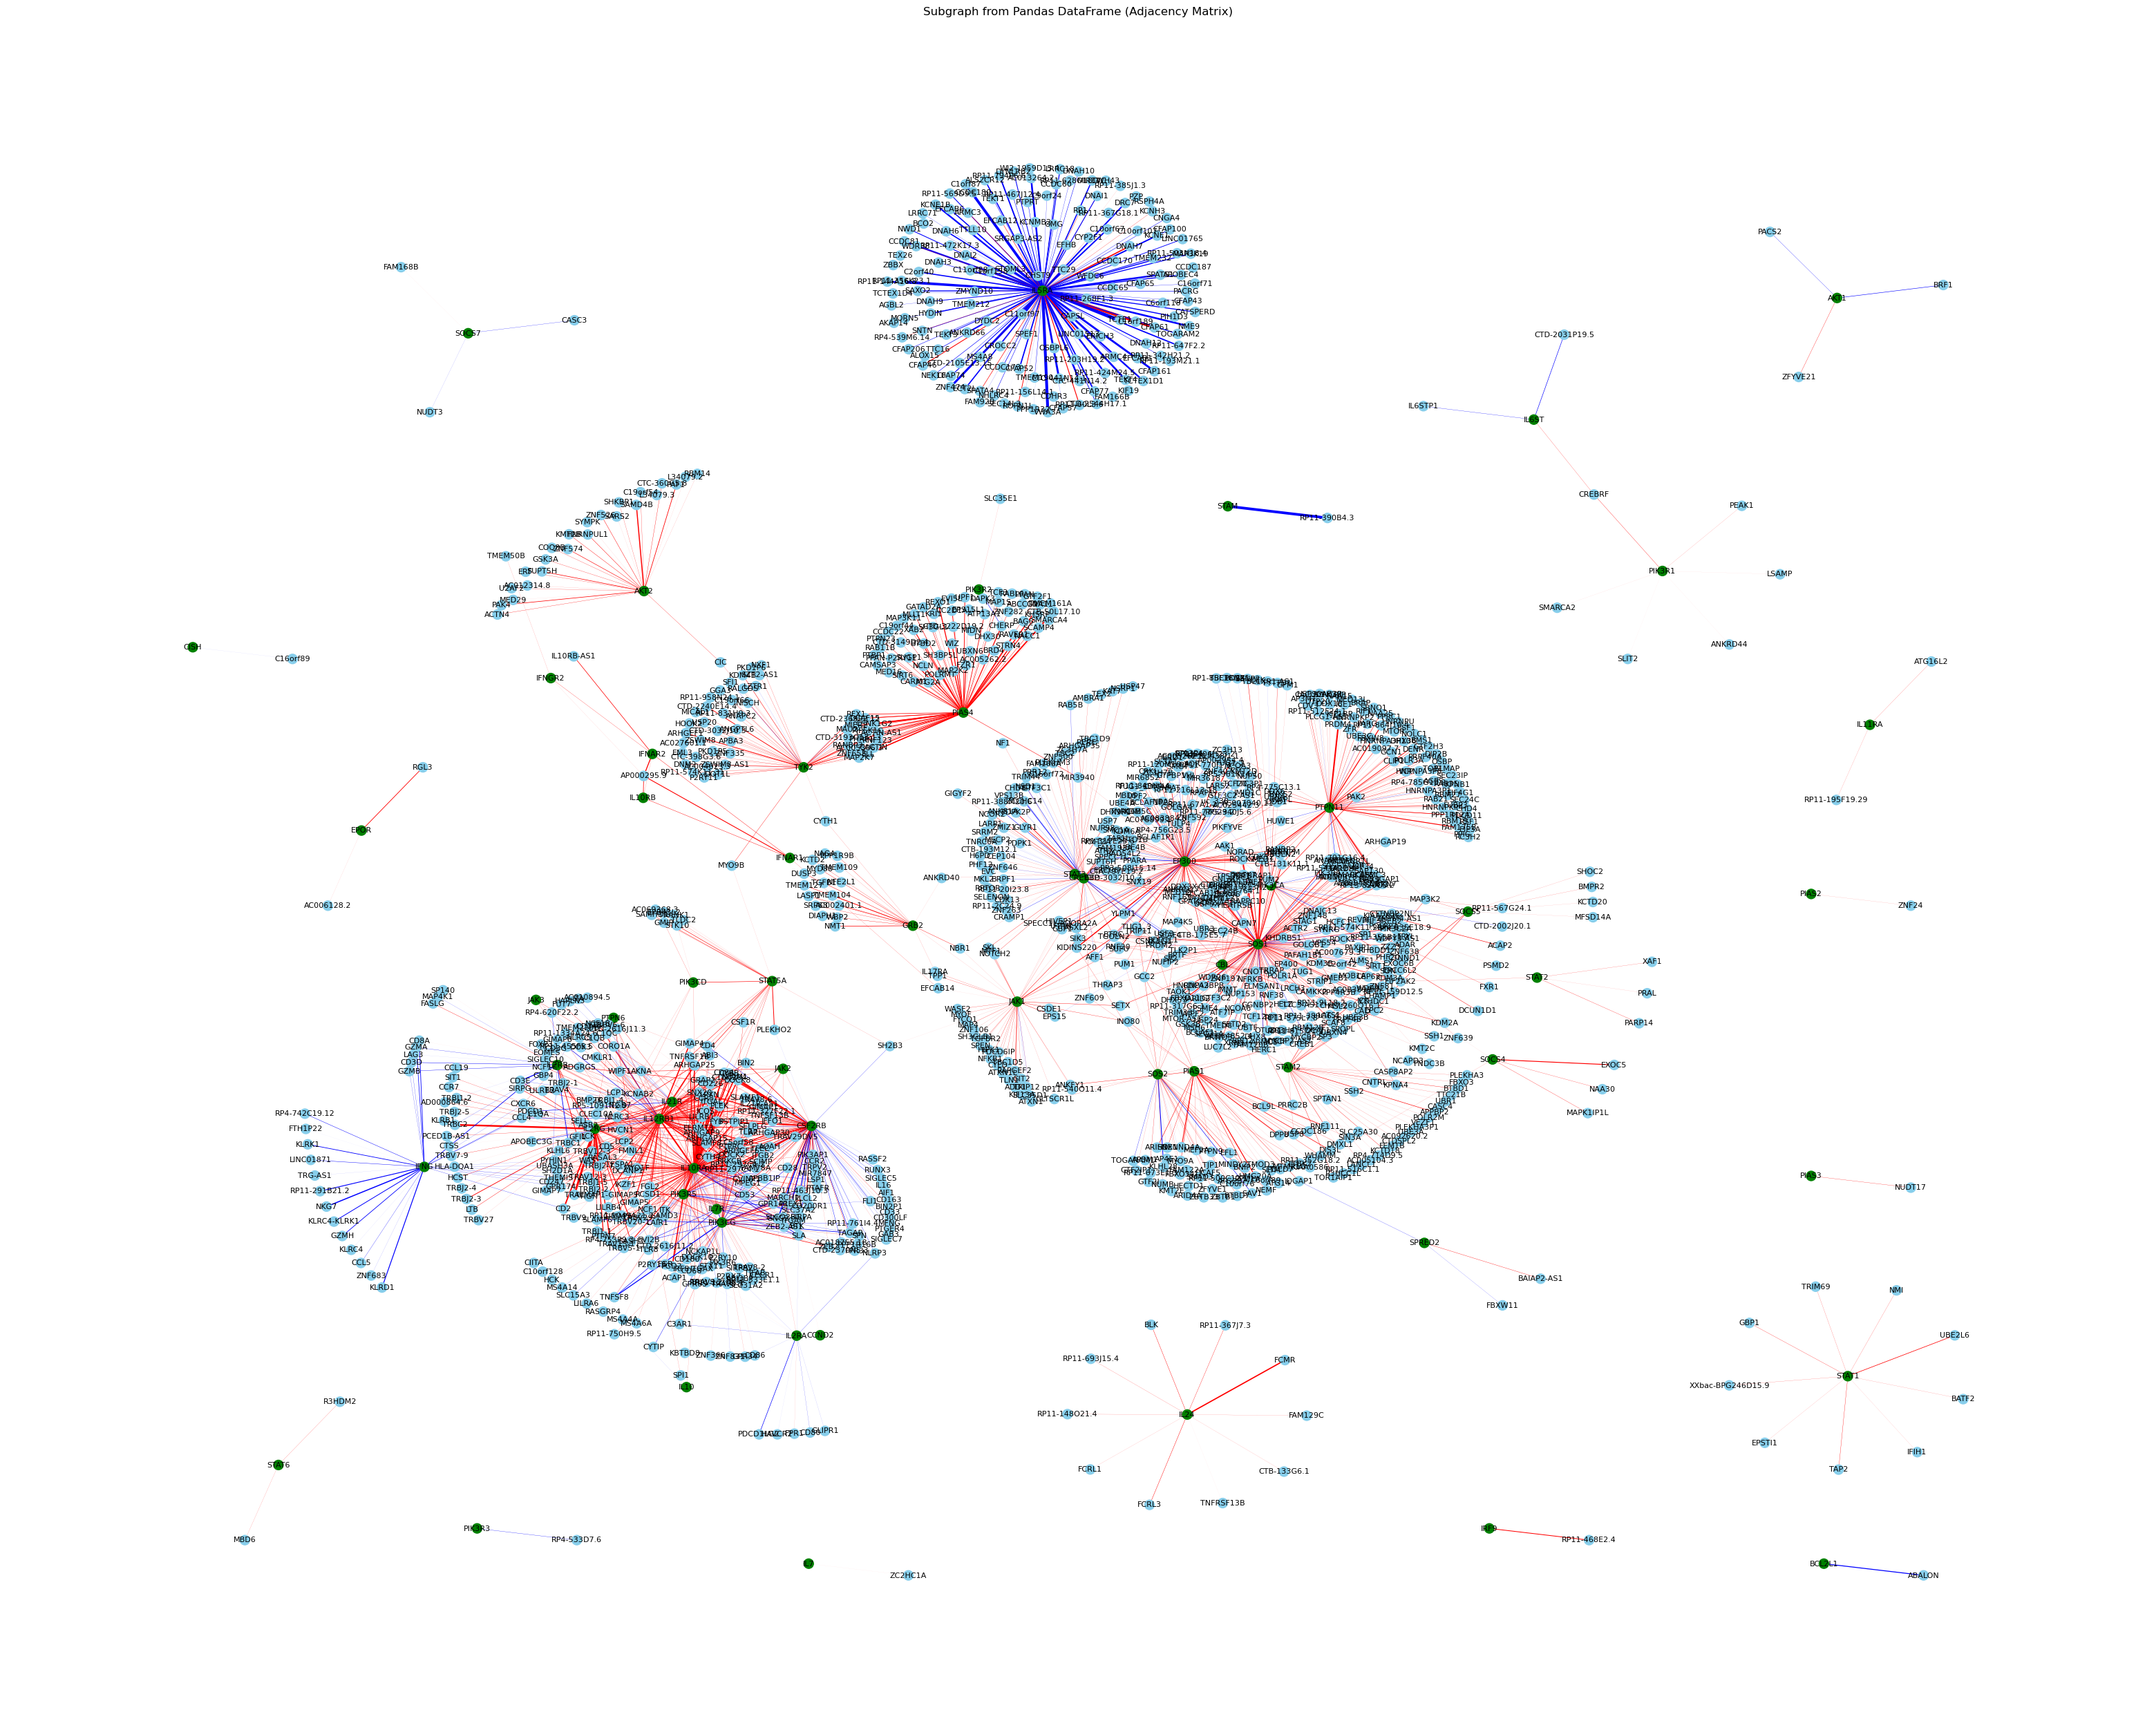

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}

# num_nodes_to_check = 1000

dif_net = dataloader.graphs[0].subtract(dataloader.graphs[1])

# borda_rankings['1vs2'].sort_values(by='borda_ranks',ascending=False, inplace=True)
# specific_nodes = borda_rankings['1vs2'].index[:num_nodes_to_check].to_list()


dif_net.index = [ens2symbol[x] for x in dif_net.index]
dif_net.columns = [ens2symbol[x] for x in dif_net.columns]



subgraph = dif_net.loc[nodes_to_plot_mapped, :]



# genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

# specific_nodes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in specific_nodes]

# subgraph.index = [ens2symbol[x] if x in ens2symbol else x for x in subgraph.index ]
# subgraph.columns = [ens2symbol[x] if x in ens2symbol else x for x in subgraph.columns ]




# nlargest_edges_to_keep = 2000

# Convert the adjacency matrix to an edge list
edge_list = subgraph.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']

# Filtering out the diagonal elements
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]


edge_list['abs_value'] = edge_list['Weight'].abs()

# Sort the DataFrame by the absolute values, then keep the top 100
# edge_list = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(10)
edge_list = edge_list.sort_values(by='abs_value', ascending=False).head(2000)



# edge_list_red = edge_list_red.drop(columns=['abs_value'])



G = nx.from_pandas_edgelist(edge_list, source='Source', target='Target', edge_attr=True)


fig, ax = plt.subplots(figsize=(40, 32))  # You can adjust the width and height as needed

# Draw the subgraph using NetworkX
# pos = nx.kamada_kawai_layout(G)

min_weight = edge_list['Weight'].abs().min()
max_weight = edge_list['Weight'].abs().max()

edge_weights = [3.0*(np.abs(G[u][v]['Weight']) - min_weight)/(max_weight-min_weight) for u, v in G.edges]
edge_colors = ['blue' if G[u][v]['Weight'] > 0 else 'red' for u, v in G.edges]

node_colors = ['green' if node in nodes_to_plot_mapped else 'skyblue'  for node in G.nodes]

nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, edge_color=edge_colors, width=edge_weights, ax=ax,font_size=8)

plt.title("Subgraph from Pandas DataFrame (Adjacency Matrix)")
plt.show()
